# Project - Dallas Shootings

![Data Science Workflow](img/ds-workflow.png)

## Goal of Project
- A newspaper want a visualization of the shootings in Dallas with focus on subjects
- We will read data from from database and join into broader datasets
- We will explore ideas to visualize it and create a map with the shootings

## Step 1: Acquire
- Explore problem
- Identify data
- Import data

### Step 1.a: Import libraries
- Execute the cell below (SHIFT + ENTER)

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1.b: Connect to SQLite database
- Use `sqlite3.connect(<filename>)` to connect to the database `files/dallas-ois.sqlite`

In [2]:
conn = sqlite3.connect('files/dallas-ois.sqlite')

### Step 1. c: Read data into DataFrames
- The database consists of 3 tables: `incident`, `officers`, `subjects`
- Read the data from each table into a DataFrame.
- HINT: Use `pandas` `read_sql(sql_stmt, conn)`, which takes the SQL statement (`sql_stmt`) and the data base connection `conn` from previous step.
- HINT: The structure of the SQL statement is as follows.
```SQL 
SELECT * FROM table
```

In [5]:
incidents = pd.read_sql("SELECT * FROM incidents",conn)
incidents.head(2)

,case_number,date,location,subject_statuses,subject_weapon,subjects,subject_count,officers,officer_count,grand_jury_disposition,attorney_general_forms_url,summary_url,summary_text,latitude,longitude
0,44523A,2013-02-23,3000 Chihuahua Street,Injured,Handgun,"Curry, James L/M",1,"Patino, Michael L/M; Fillingim, Brian W/M",2,No Bill,None,http://dallaspolice.net/reports/OIS/narrative/...,"On Saturday, February 23, 2013, at approximate...",NaN,NaN
1,121982X,2010-05-03,1300 N. Munger Boulevard,Injured,Handgun,"Chavez, Gabriel L/M",1,"Padilla, Gilbert L/M",1,No Bill,None,http://dallaspolice.net/reports/OIS/narrative/...,"On Monday, May 3, 2010, at approximately 8:06 ...",NaN,NaN


In [6]:
officers = pd.read_sql("SELECT * FROM officers",conn)
officers.head(2)

,case_number,race,gender,last_name,first_name,full_name
0,44523A,L,M,Patino,Michael,"Patino, Michael"
1,44523A,W,M,Fillingim,Brian,"Fillingim, Brian"


In [7]:
subjects = pd.read_sql("SELECT * FROM subjects",conn)
subjects.head(2)

,case_number,race,gender,last_name,first_name,full_name
0,44523A,L,M,Curry,James,"Curry, James"
1,121982X,L,M,Chavez,Gabriel,"Chavez, Gabriel"


### Step 1.d: Explore the length of the DataFrames
- What is the length of the DataFrames
    - HINT: Apply `len(...)` on the DataFrames
- We want to explore data based on officers and data based on subjects, both with incident data.
- Notice: It is difficult to create one dataset for both problems
- Explore data further to understand why

In [9]:
len(officers)

370

In [10]:
len(incidents)

219

In [11]:
len(subjects)

223

In [12]:
officers.dtypes

case_number    object
race           object
gender         object
last_name      object
first_name     object
full_name      object
dtype: object

### Step 1.e: Read data into dataset
- Create first dataset `subject_incidents` as officers joined with incidents.
    - What does this dataset give us?
    - HINT:
    ```SQL
    SELECT * FROM table_1 JOIN table_2 ON table_1.column_name_1=table_2.column_name_2
    ```
    - HINT: You can join on columns `case_number`
- Is all data represented?

In [14]:
subject_incidents = pd.read_sql("SELECT * FROM subjects JOIN incidents ON subjects.case_number=incidents.case_number",conn)

In [15]:
subject_incidents.head(2)

,case_number,race,gender,last_name,first_name,full_name,case_number,date,location,subject_statuses,...,subjects,subject_count,officers,officer_count,grand_jury_disposition,attorney_general_forms_url,summary_url,summary_text,latitude,longitude
0,44523A,L,M,Curry,James,"Curry, James",44523A,2013-02-23,3000 Chihuahua Street,Injured,...,"Curry, James L/M",1,"Patino, Michael L/M; Fillingim, Brian W/M",2,No Bill,None,http://dallaspolice.net/reports/OIS/narrative/...,"On Saturday, February 23, 2013, at approximate...",NaN,NaN
1,121982X,L,M,Chavez,Gabriel,"Chavez, Gabriel",121982X,2010-05-03,1300 N. Munger Boulevard,Injured,...,"Chavez, Gabriel L/M",1,"Padilla, Gilbert L/M",1,No Bill,None,http://dallaspolice.net/reports/OIS/narrative/...,"On Monday, May 3, 2010, at approximately 8:06 ...",NaN,NaN


## Step 2: Prepare
- Explore data
- Visualize ideas
- Cleaning data

### Step 2.a: Check the data types
- A step to get to understand the data better is to explore the data types
- Get the data types by `.dtypes`

In [16]:
subject_incidents.dtypes

case_number                    object
race                           object
gender                         object
last_name                      object
first_name                     object
full_name                      object
case_number                    object
date                           object
location                       object
subject_statuses               object
subject_weapon                 object
subjects                       object
subject_count                   int64
officers                       object
officer_count                   int64
grand_jury_disposition         object
attorney_general_forms_url     object
summary_url                    object
summary_text                   object
latitude                      float64
longitude                     float64
dtype: object

### Step 2.b: Check for null (missing) values
- Data often is missing entries - there can be many reasons for this
- We need to deal with that (will do later in course)
- Use ```.isna().sum()```

In [17]:
subject_incidents.isna().sum()

case_number                     0
race                            0
gender                          0
last_name                       0
first_name                     18
full_name                       0
case_number                     0
date                            0
location                        0
subject_statuses                0
subject_weapon                  0
subjects                        0
subject_count                   0
officers                        0
officer_count                   0
grand_jury_disposition         88
attorney_general_forms_url    221
summary_url                     3
summary_text                    3
latitude                        9
longitude                       9
dtype: int64

### Step 2.c: Explore subject_statuses column
- As part of finding useful features let's explore `subject_statuses`
- We know that `subject_statuses` is categorical.
- Therefore we can use `groupby(...)` and `count()`

In [20]:
subject_statuses = subject_incidents.groupby('subject_statuses').count()
subject_statuses.head(2)

,case_number,race,gender,last_name,first_name,full_name,case_number,date,location,subject_weapon,subjects,subject_count,officers,officer_count,grand_jury_disposition,attorney_general_forms_url,summary_url,summary_text,latitude,longitude
subject_statuses,,,,,,,,,,,,,,,,,,,,
1 Deceased 1 Injured,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
2 Injured,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1


### Step 2.d: Explore race column
- Repeat of previous step on column `race`

In [21]:
race = subject_incidents.groupby('race').count()
race.head()

,case_number,gender,last_name,first_name,full_name,case_number,date,location,subject_statuses,subject_weapon,subjects,subject_count,officers,officer_count,grand_jury_disposition,attorney_general_forms_url,summary_url,summary_text,latitude,longitude
race,,,,,,,,,,,,,,,,,,,,
A,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,2,2,2
B,111,111,111,104,111,111,111,111,111,111,111,111,111,111,67,0,109,109,106,106
L,72,72,72,61,72,72,72,72,72,72,72,72,72,72,37,2,71,71,68,68
W,38,38,38,38,38,38,38,38,38,38,38,38,38,38,31,0,38,38,38,38


### Step 2.e: Explore more columns
- Feel free to explore more columns (also called features)

In [23]:
location = subject_incidents.groupby('location').count()
location.head(2)

,case_number,race,gender,last_name,first_name,full_name,case_number,date,subject_statuses,subject_weapon,subjects,subject_count,officers,officer_count,grand_jury_disposition,attorney_general_forms_url,summary_url,summary_text,latitude,longitude
location,,,,,,,,,,,,,,,,,,,,
10008 Mesita Drive,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
10200 Walton Walker Boulevard,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1


### Step 2.f: Visualize ideas
- We want to make a visual plot of the shooting incident
- Let's explore if we can make a plot based on longitude and latitude.
    - HINT: use `plot.scatter(x='longitude', y='latitude')`
- Then the analysis phase will focus on how to make useful insights with the feature selections.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

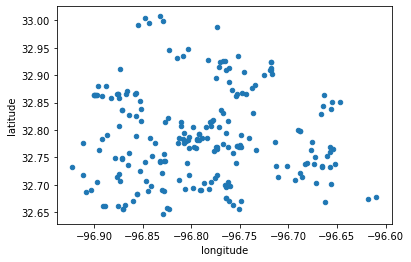

In [24]:
subject_incidents.plot.scatter(x='longitude', y='latitude')

## Step 3: Analyze
- Feature selection
- Model selection
- Analyze data

### Step 3.a: Feature selection
- Here we will continue with the features selected feel free to explore other features.
- Create a `dataset` with the features: `race`, `subject_statuses`, `latitude`, `longitude`
    - HINT: Select the features of the DataFrame `subject_incidents` by filtering with a list of the columns.
- To make further processing easier apply `dropna()` to remove missing data.

In [25]:
dataset = subject_incidents[['latitude','longitude','subject_statuses','race']]
dataset.head(2)

,latitude,longitude,subject_statuses,race
0,NaN,NaN,Injured,L
1,NaN,NaN,Injured,L


In [28]:
dataset = dataset.dropna(axis=0)
dataset.head(2)

,latitude,longitude,subject_statuses,race
9,32.68642,-96.908674,Deceased,L
10,32.86400,-96.898998,Deceased,B


### Step 3.b: How to visualize features
- We want to visualize the two features: `race` and `subject_statuses`
- A way to visualize data is by color and size.
- Idea:
    - Map the race features to colors
    - Map the subject_statuses to a size

### Step 3.b.1: Convert column
- The `race` column has the following categories: B, W, A, L
- We can map that to color values ([docs](https://matplotlib.org/stable/gallery/color/named_colors.html))
- A simple way to map columns is by using `apply` on a lambda-function.
    - Create a dict with the mapping:
    ```Python
mapping = {'B': 'blue', 'W': 'yellow', 'A': 'red', 'L': 'cyan'}
```
    - Do the mapping with `apply`and `lambda` as follows
    ```Python
dataset['race'] = dataset['race'].apply(lambda x: mapping[x])
```

In [29]:
mapping = {'B': 'blue', 'W': 'yellow', 'A': 'red', 'L': 'cyan'}
dataset['race'] = dataset['race'].apply(lambda x: mapping[x])
dataset['race']

9        cyan
10       blue
11     yellow
12       blue
13       blue
        ...  
218      blue
219      blue
220      cyan
221      blue
222      blue
Name: race, Length: 214, dtype: object

### Step 3.b.2: Convert column
- The `subject_statuses` has the following categories: `'1 Deceased 1 Injured', '2 Injured', 'Deceased', 'Deceased Injured', 'Injured', 'Other', 'Shoot and Miss'`
- The main categories are: `'Deceased', 'Injured', 'Shoot and Miss'`
- A simple way is quite similar to last step.
    - Create a mapping of the main categories:
    ```Python
mapping = {'Deceased': 1000, 'Injured': 500, 'Shoot and Miss': 250}
```
    - Do the mapping with `apply`and `lambda` as follows
    ```Python
dataset['subject_statuses'] = dataset['subject_statuses'].apply(lambda x: mapping.get(x, 100))
```

In [31]:
mapping = {'Deceased': 1000, 'Injured': 500, 'Shoot and Miss': 250}
dataset['subject_statuses'] = dataset['subject_statuses'].apply(lambda x: mapping.get(x, 100))
dataset['subject_statuses']

9      100
10     100
11     100
12     100
13     100
      ... 
218    100
219    100
220    100
221    100
222    100
Name: subject_statuses, Length: 214, dtype: int64

### Step 3.c: Visualize the data
- Now we can visualize the data
- This can be done with a scatter plot
```Python
dataset.plot.scatter(x='longitude', y='latitude', s='subject_statuses', c='race', alpha=.5)
```
- Where `s=` is the size feature and `c=` is the color feature, `figsize=` sets the size of the figure, `alpha=` sets the transparency of the dots.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

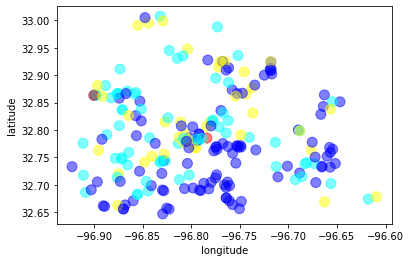

In [34]:
dataset.plot.scatter(x='longitude', y='latitude', s='subject_statuses', c='race', alpha=.5)

## Step 4: Report
- Present findings
- Visualize results
- Credibility counts

### Step 4.a: Present a chart
- The goal here is to present your message
- Visualize one chart
- Add a headline (title) to give the audience a message

ValueError: x must be a label or position

### Step 4.b (Optional): Further improvements
- Ideas to improve the visualization
- Add description (legends) with color and size description.
- Visualize it on a map
    - You could use [folium](https://python-visualization.github.io/folium/)
    - Explore [quick guide](https://python-visualization.github.io/folium/quickstart.html)

In [39]:
!pip install folium
import folium

     |████████████████████████████████| 95 kB 545 kB/s eta 0:00:01


In [44]:
dataset

,latitude,longitude,subject_statuses,race
9,32.68642,-96.908674,100,cyan
10,32.86400,-96.898998,100,blue
11,32.81482,-96.826787,100,yellow
12,32.77540,-96.767489,100,blue
13,32.74417,-96.828470,100,blue
...,...,...,...,...
218,32.65628,-96.869793,100,blue
219,32.70483,-96.779494,100,blue
220,32.79473,-96.764017,100,cyan
221,32.81664,-96.851409,100,blue


In [47]:
m = folium.Map(location=[32.7767,-96.7970], tiles="Stamen Toner", zoom_start=13)

folium.Circle(
    radius=100,
    location=[32.68642,-96.908674],
    popup="The Demo1",
    color="green",
    fill=False,
).add_to(m)

folium.CircleMarker(
    location=[32.77945,-96.804915],
    radius=50,
    popup="Demo2",
    color="#3186cc",
    fill=True,
    fill_color="#3186cc",
).add_to(m)


m

## Step 5: Actions
- Use insights
- Measure impact
- Main goal

### Step 5.a (Optional): Are there any insights?
- Any insights you want to highlight?
- Any future measurements?